In [1]:
%matplotlib inline
from __future__ import division
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display_javascript

from vis_common import load_store, load_games

FS = (10, 6) # Reasonable default figsize
DECILES = list(np.arange(0.1, 1.0, 0.1))

store = load_store()
g = games = load_games()

In this post, I'll be taking a step back and doing some analysis at the level of players of DCSS, rather than individual games. How many players do we have?

In [2]:
print "{:,} distinct players among {:,} games".format(
    g['pid'].unique().shape[0], len(g)
)
print
print "Distribution of games played per player..."
print
print g.groupby('pid').size().describe()

26,004 distinct players among 1,326,162 games

Distribution of games played per player...

count    26004.000000
mean        50.998385
std        201.641369
min          1.000000
25%          1.000000
50%          3.000000
75%         20.000000
max       8170.000000
dtype: float64


The "average" player has 50 games, though this statistic is pretty misleading. A majority of players can count their games on one hand. 

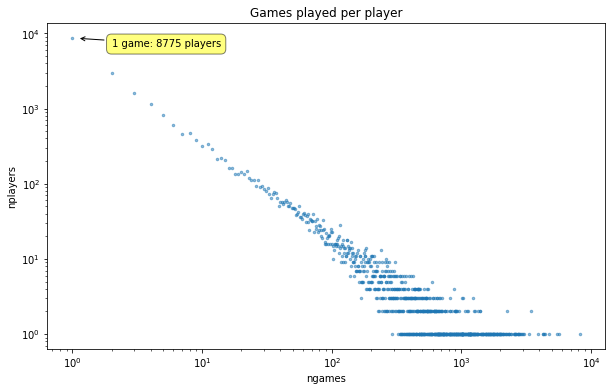

In [3]:
count_counts = g.groupby('pid').size().value_counts().to_frame('nplayers')
count_counts['ngames'] = count_counts.index
fig, ax = plt.subplots(figsize=FS)
ax.scatter(count_counts['ngames'], count_counts['nplayers'], marker='.', s=25, alpha=.5)
onegame = count_counts.loc[1]['nplayers']
ax.annotate("1 game: {} players".format(onegame), 
            xy=(1.1, onegame*.98), xytext=(2, onegame*.75),
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0')
           )
ax.set_xlabel('ngames')
ax.set_ylabel('nplayers')
ax.set_title("Games played per player")
ax.loglog();

A straight line on a log-log plot. Looks like some kind of power-law distribution. 

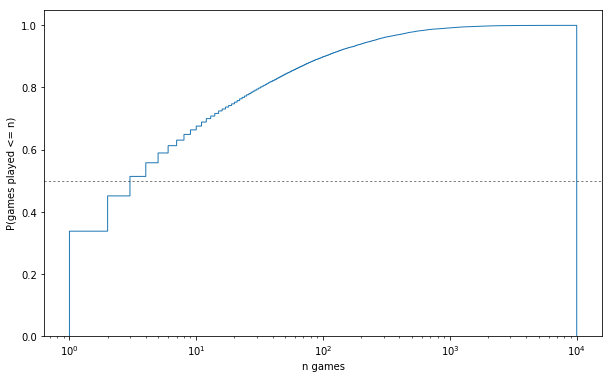

In [4]:
fig, ax = plt.subplots(figsize=FS)
counts = g.groupby('pid').size().values
n, bins, patches = ax.hist(counts, 
                           np.arange(1, 10**4),
                           #np.logspace(0, 4, 150),
       normed=1, histtype='step', cumulative=1
)
midpoint = (n >= .5).argmax()
midpct = 100 * n[midpoint]
ax.set_xscale('log');
ax.axhline(y=.5, color='black', linestyle=':', linewidth=.5);
ax.set_xlabel('n games')
ax.set_ylabel('P(games played <= n)');

In [5]:
print '{:.1f}% of players have <= {} games'.format(
    midpct, midpoint+1)

51.4% of players have <= 3 games


What about the distribution of wins across players?

In [6]:
gpp = games_per_pid = g.groupby('pid').size()
wpp = wins_per_pid = g.groupby('pid')['won'].sum()
wpp = wins_per_pid
print "{:,} / {:,} players have won at least one game".format(
    (wpp > 0).sum(), len(wpp)
)

2,111 / 26,004 players have won at least one game


That statistic certainly speaks to DCSS's difficulty. **>90%** of players have never won a game.

In [7]:
print "Do winners account for more games?"
winpids = wpp.where(lambda wins: wins > 0).dropna().index
print "Avg. number of games played by...\n\twinners: {:.1f}\n\tnon-winners: {:.1f}".format(
    g[g['pid'].isin(winpids)].groupby('pid').size().mean(),
    g[~g['pid'].isin(winpids)].groupby('pid').size().mean(),
)
winnergames = g['pid'].isin(winpids).sum()
print "{:,} out of {:,} games ({:.1f}%) were played by players who have won a game".format(
    winnergames, len(g), 100*winnergames/len(g),
)

Do winners account for more games?
Avg. number of games played by...
	winners: 305.3
	non-winners: 28.5
644,434 out of 1,326,162 games (48.6%) were played by players who have won a game


In [8]:
gameticks = [1, 2, 5, 10, 25, 50, 100, 250, 
                          500, 1000, 2000, 4000,
                          10000]
winticks = [1, 2, 5, 10, 25, 50, 100]
def scatter_games_v_wins(minwins=0, jitter=False):
    fig, ax = plt.subplots(figsize=FS)
    wins = wpp[wpp >= minwins]
    winjitter = 0
    if jitter:
        winjitter = (np.random.rand(len(wins)) - .5) * .55
    ax.scatter(gpp.loc[wins.index], wins.values + winjitter,
              alpha=.1,
              )
    ax.set_yscale('symlog' if minwins==0 else 'log')
    ax.set_xscale('log')
    ax.set_xticks(gameticks)
    ax.set_yticks(winticks);
    ax.set_xticklabels([str(i) for i in gameticks])
    ax.set_yticklabels([str(i) for i in winticks]);
    ax.set_xlabel('Games')
    ax.set_ylabel('Wins')
    ax.set_title("Games vs. wins per player")
    return ax

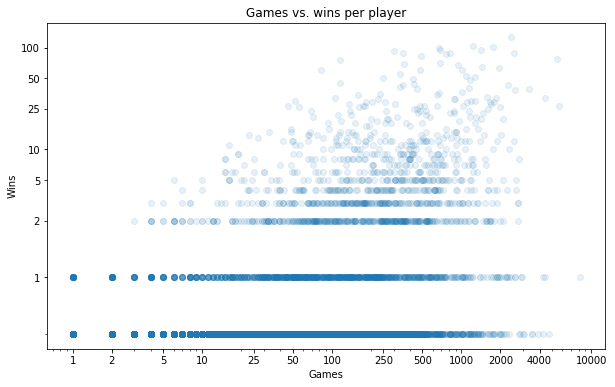

In [9]:
scatter_games_v_wins();

Here I'm placing a dot for each player, according to their number of games played and number of wins (still on a log-log scale). It's hard to get a sense of what's going on in those stripes that form at 0/1/2 wins. We can maybe get a better sense of the density by randomly jittering each point in the y direction:

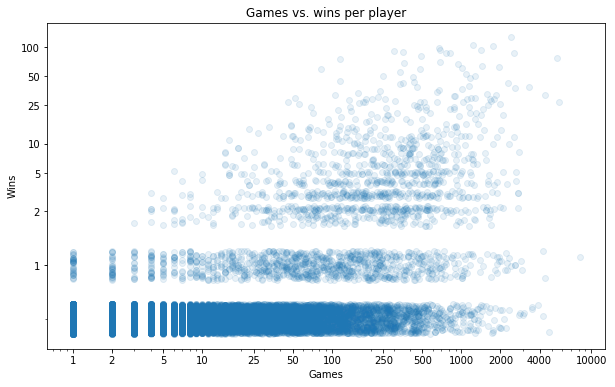

In [10]:
scatter_games_v_wins(jitter=1);

We already knew there were a *lot* of players with 0 wins (more than 90% of all players). But it's interesting to see that this isn't just a result of having lots of players who have played a tiny number of games. There are many people who have played 100+ games without a win.

Let's turn our attention to just the players with at least 1 win.

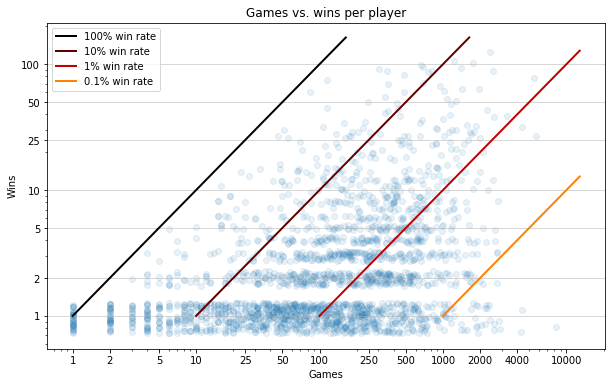

In [11]:
ax = scatter_games_v_wins(minwins=1, jitter=1)
ax.grid(axis='y', lw=.5);
ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()
ymin = 1
cmap = plt.get_cmap('gist_heat')
winrate_lines = [.001, .01, .1, 1.0]
for i, wr in enumerate(reversed(winrate_lines)):
    p1 = [ymin/wr, ymin]
    if xmax*wr <= ymax:
        p2 = [xmax, xmax*wr]
    else:
        p2 = [ymax/wr, ymax]
    xs, ys = zip(p1, p2)
    ax.plot(xs,
            ys,
            label=('{}% win rate'.format(int(wr*100)) if wr >= .01
                   else '{:.1f}% win rate'.format(wr*100)),
            color=cmap(i/len(winrate_lines)),
            linewidth=2, linestyle='-',
    )
ax.legend();

Eyeballing the diagonal guides, it seems like the greatest density is around the 1% win rate, with the vast majority falling somewhere between 0.1 and 10%.

There appear to be a fair number of players with a 100% win rate over 1 game.

In [12]:
perfect = gpp == wpp
print "{} players have a perfect record (avg. number of games played = {})".format(
    perfect.sum(), gpp[perfect].mean(),
)

37 players have a perfect record (avg. number of games played = 1.0)


Far more impressive are those few dots with a >50% win rate over 50+ games.

In [13]:
wrpp = g[g['pid'].isin(gpp[gpp >= 50].index)].groupby('pid')['won'].mean().rename('winrate')
tops = wrpp.sort_values(ascending=0).head(3)
players = store['players']
print pd.concat([
    players.loc[tops.index].rename('name'),
    wpp.loc[tops.index].rename('wins').astype(int),
    gpp.loc[tops.index].rename('games'),
    tops.round(2),     
], axis=1)

                  name  wins  games  winrate
pid                                         
17003       jumbajumba    60     83     0.72
6203   makemeasandwich    75    115     0.65
8250          hellmonk    30     52     0.58


You go, [jumbajumba](http://crawl.akrasiac.org/scoring/players/jumbajumba.html)!

## Winrates


In [14]:
import winrate
g['raw winrate'] = g.groupby('pid')['won'].mean().loc[g['pid']].values
g['wr'] = winrate.smoothed_winrate(g)
#print "Distribution of raw/smoothed winrates over players...\n"
#print (100*g.groupby('pid')[['raw winrate', 'wr']].mean()).rename(columns={'wr': 'smoothed winrate'})\
#    .describe([.1, .25, .5, .75, .9, .95, .975, .99, .995])
rwrpp = g.groupby('pid')['raw winrate'].first()
wrpp = g.groupby('pid')['wr'].first()

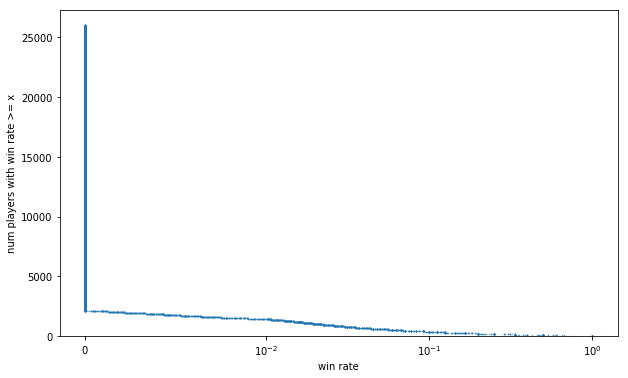

In [15]:
fig, ax = plt.subplots(figsize=FS)
order = -1
#ax.step(np.sort(wrpp.values)[::order], np.arange(len(wrpp))+1, label='smoothed', alpha=.7, lw=0, marker='.');
#ax.step(np.sort(rwrpp.values)[::order], np.arange(len(rwrpp))+1, label='raw');
ax.plot(np.sort(rwrpp.values)[::order], np.arange(len(rwrpp))+1, label='raw', alpha=.7,
        lw=0, marker='.', ms=1,
       );
xlin = 10**-2
ax.set_xscale('symlog', linthreshx=xlin);
ax.set_xlabel('win rate')
ax.set_ylabel('num players with win rate >= x')
ax.set_ylim(bottom=0);

We already know >90% of players have a 0% winrate. We might get a less L-shaped curve if we map each game to the winrate of the corresponding player, and look at the distribution of win rates across games.

(This is motivated by questions we may want to ask like "Are deep dwarves favoured by skilled players?", or "Do good players clear the Elven Halls more often than newbs?". A natural way to answer these kinds of questions is to select the games where foo happened, and look at the posterior distribution of winrates over those games.)

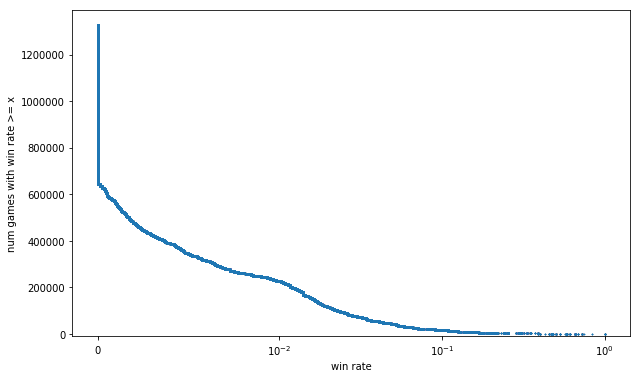

In [16]:
fig, ax = plt.subplots(figsize=FS)
order = -1
#ax.step(np.sort(g['wr'])[::order], np.arange(len(g))+1, label='smoothed', alpha=.7);
#ax.step(np.sort(g['raw winrate'])[::order], np.arange(len(g))+1, label='raw', alpha=.7);
ax.plot(np.sort(g['raw winrate'])[::order], np.arange(len(g))+1, label='raw', alpha=.7,
        lw=0, marker='.', ms=1,
       );
xlin = rwrpp[rwrpp > 0].min()
xlin = 10**-2
ax.set_xscale('symlog', linthreshx=xlin)
ax.set_xlabel('win rate')
ax.set_ylabel('num games with win rate >= x')
#ax.legend()
ax.set_ylim(bottom=-10000);

This is definitely smoother than the previous curve, but using raw winrate to measure skill leads to some silly outcomes, particularly at the extremes:

- The curve extends all the way to 100%, because of those 37 players with records of 1 win 0 losses. We shouldn't be so naive as to believe that if we had them play another 10 games each, they'd win them all.
- We still map about half of all games to the same win rate of 0%. It'd be nice to be able to differentiate among them. Intuitively, it seems like a player with 0 wins 1 loss should be ranked ahead of one with 0 wins 300 losses.

This problem is involved enough that I devoted a whole separate post to it: [Estimating player skill in DCSS](/blog/dcss_winrates). Here's a sneak peek of the smoothed estimate of win rate I came up with, compared to raw win rate.

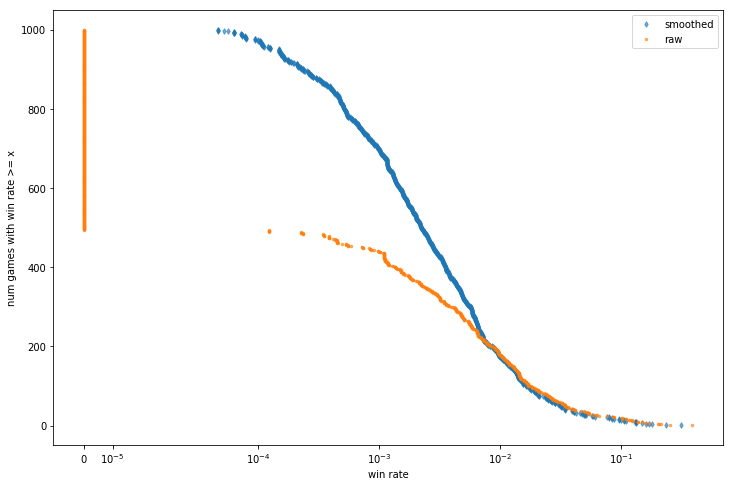

In [17]:
fig, ax = plt.subplots(figsize=(12, 8))
order = -1
plot_kwargs = dict(lw=0, alpha=.6)
n = 1000
seed = 1337
if n:
    ax.plot(np.sort(g['wr'].sample(n, random_state=seed))[::order], 
            np.arange(n)+1, 
            label='smoothed', marker='d', ms=4,
            **plot_kwargs
           );
    ax.plot(np.sort(g['raw winrate'].sample(n, random_state=seed))[::order], 
            np.arange(n)+1, 
            label='raw', marker='.', ms=5,
            **plot_kwargs
           );
else:
    ax.plot(np.sort(g['wr'])[::order], np.arange(len(g))+1, label='smoothed', ms=40, alpha=1,
            **plot_kwargs
           );
    ax.plot(np.sort(g['raw winrate'])[::order], np.arange(len(g))+1, label='raw', ms=5, alpha=1,
            **plot_kwargs
           );
xlin = g['wr'].min()
#xlin = rwrpp[rwrpp > 0].min()
ax.set_xscale('symlog', linthreshx=xlin)
ax.set_xlabel('win rate')
ax.set_ylabel('num games with win rate >= x')
ax.legend();
#ax.set_ylim(bottom=-10000);

The most drastic effect is that all the zeroes are gone. Even if a player has lost 500 games in a row, we're going to optimistically guess that, if they played another 9500, they would probably win one. Being able to distinguish the mediocre from the truly abysmal will turn out to be useful, for example when [identifying newbie traps in DCSS](/blog/dcss_newbie_traps).